**Table of contents**<a id='toc0_'></a>    
- [Introduction](#toc1_)    
- [Preparations before tutorials](#toc2_)    
    - [Loading package](#toc2_1_1_)    
  - [Prepare data](#toc2_2_)    
    - [View meta information](#toc2_2_1_)    
    - [Visulize batch effect of raw data](#toc2_2_2_)    
- [Integration of Alzheimer’s disease dataset with scFLASH](#toc3_)    
  - [Build scFLASH model input](#toc3_1_)    
  - [Create scFLASH model.](#toc3_2_)    
  - [Train  scFLASH model](#toc3_3_)    
  - [Get the integrated result](#toc3_4_)    
  - [Visualization of the corrected gene expression data](#toc3_5_)    
  - [Evaluation](#toc3_6_)    
- [Reference](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Introduction](#toc0_)

scFLASH is a novel single-cell data integration method that seamlessly integrates single-cell datasets across different batches and conditions. It effectively corrects gene expression, preserves condition-specific differences, and removes technical noise, while also identifying condition-specific cells. Importantly, scFLASH is versatile and can handle diverse integration tasks, merging datasets from two or more conditions and various batch types.

Here we will demonstrate scFLASH's functionality through integrative analysis of an Alzheimer’s disease (AD) snRNA-seq dataset.

# <a id='toc2_'></a>[Preparations before tutorials](#toc0_)

Before starting the tutorial, we need to do some preparations, including: installing scFLASH and its required Python packages, etc. These preparations can be completed by following the step-by-step installation guide provided in the `README`.

### <a id='toc2_1_1_'></a>[Loading package](#toc0_)

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import required packages
import scFLASH
import scanpy as sc
sc.settings.verbosity = 0  # Set verbosity: errors (0), warnings (1), info (2), hints (3)

## <a id='toc2_2_'></a>[Prepare data](#toc0_)
The raw Alzheimer’s disease dataset can be downloaded from [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE138852) and preprocessed data is available in the ./tutorial_data/ folder for direct use. In the following sections, we use the preprocessed data provided in `./tutorial_data/` as an example to demonstrate the integration process.
We read the processed AD dataset. The dataset includes:

1) The preprocessed expression matrix in `adata.X`;
   
2) Metadata information of cells, including three observation labels： `"batch"`, `"celltype"`, and `"condition"`.
  
Note that the integration process of scFLASH requires the above three labels, please ensure the same anndata structure as example.

In [3]:
import gzip

with gzip.open("../tutorial_data/AD_preprocessed.h5ad.gz", "rb") as f_in:
    adata = sc.read_h5ad(f_in)

adata

AnnData object with n_obs × n_vars = 11884 × 2000
    obs: 'batch', 'celltype', 'condition'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

Besides, if the data is a raw count matrix, we provided a preprocessing function `scFLASH.preprocess(adata)` wrapped by scanpy analysis pipeline.

### <a id='toc2_2_1_'></a>[View meta information](#toc0_)

In [4]:
scFLASH.print_dataset_information(adata,"batch","condition")

===========print brief information of dataset ===============
===========there are 6 batchs in this dataset==============
===========there are 2 conditions with this dataset=========


condition,AD,ct,Total
batch,,,
AD1_AD2,2209,0,2209
AD3_AD4,2570,0,2570
AD5_AD6,985,0,985
Ct1_Ct2,0,796,796
Ct3_Ct4,0,3009,3009
Ct5_Ct6,0,2315,2315
Total,5764,6120,11884


In [5]:
scFLASH.print_dataset_information(adata,"batch","celltype")

===========print brief information of dataset ===============
===========there are 6 batchs in this dataset==============
===========there are 6 celltypes with this dataset=========


celltype,OPC,astro,endo,mg,neuron,oligo,Total
batch,,,,,,,
AD1_AD2,32,96,5,21,99,1956,2209
AD3_AD4,57,235,2,87,114,2075,2570
AD5_AD6,90,141,30,64,36,624,985
Ct1_Ct2,88,166,11,54,68,409,796
Ct3_Ct4,427,853,32,142,124,1431,3009
Ct5_Ct6,384,680,18,81,215,937,2315
Total,1078,2171,98,449,656,7432,11884


### <a id='toc2_2_2_'></a>[Visulize batch effect of raw data](#toc0_)

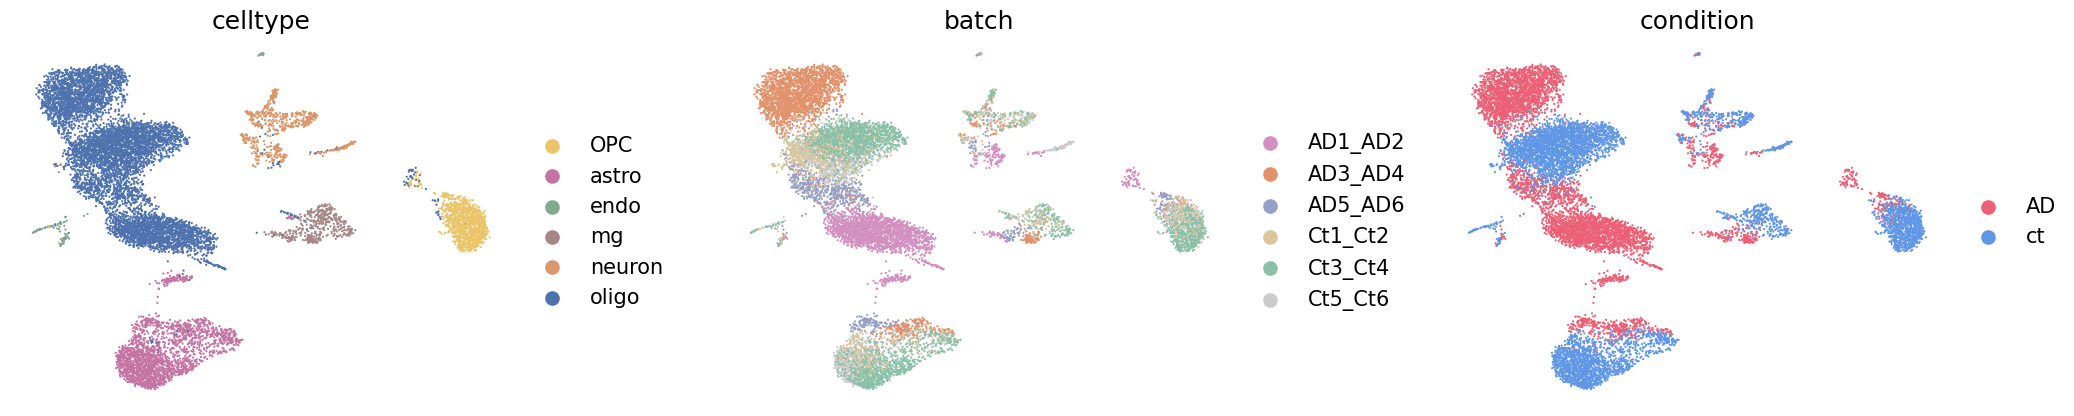

In [6]:
warnings.filterwarnings("ignore")

adata.uns["celltype_colors"] = ['#ebc467', '#c573a3', '#82a98e', '#a58786', '#da986a','#4e72ae']
adata.uns["batch_colors"] = ['#d28fc0', '#e2926b','#95a0c7','#dbc59a', '#89c0a7', '#cbcbcc']
adata.uns["condition_colors"] = ["#ec5f74","#6096e6"]

color_group = ['celltype','batch',"condition"]

sc.pl.umap(adata, color=color_group,legend_fontsize=15,wspace=0.3, frameon=False,size=10)

# <a id='toc3_'></a>[Integration of Alzheimer’s disease dataset with scFLASH](#toc0_)

## <a id='toc3_1_'></a>[Build scFLASH model input](#toc0_)

* The next step is to format `adata` to create the input for `scFLASH`. The function `prepare_anndata` will structure the data and include necessary metadata, making it ready for model integration. 
  
    + **Output**: A dictionary (`input_dict`) containing processed data and key metrics.


In [7]:
input_dict  = scFLASH.prepare_anndata(adata, batch_key="batch", condition_key="condition")

Data matrix shape: (11884, 2000)
Condition proportions: [0.48502188 0.51497812]
Condition ratio vector: [0.48502188 0.48502188 0.48502188 ... 0.48502188 0.48502188 0.48502188]
Batch proportions: [0.18588018 0.21625715 0.08288455 0.06698081 0.25319758 0.19479973]
Index of maximum batch count: 4


In [8]:
input_dict 

{'exp': array([[-0.13394736, -0.16900508, -0.3063591 , ..., -0.2365799 ,
         -0.5565052 , -0.14840177],
        [-0.13394736, -0.16900508, -0.3063591 , ..., -0.2365799 ,
         -0.5565052 , -0.14840177],
        [-0.13394736, -0.16900508, -0.3063591 , ...,  3.5615804 ,
          1.2389896 , -0.14840177],
        ...,
        [-0.13394736, -0.16900508, -0.3063591 , ..., -0.2365799 ,
         -0.5565052 , -0.14840177],
        [-0.13394736, -0.16900508, -0.3063591 , ..., -0.2365799 ,
         -0.5565052 , -0.14840177],
        [ 7.782988  , -0.16900508, -0.3063591 , ..., -0.2365799 ,
          1.4812428 , -0.14840177]], dtype=float32),
 'meta':                             batch celltype condition
 AAACCTGGTAGAAAGG_AD5_AD6  AD5_AD6    oligo        AD
 AAACCTGGTAGCGATG_AD5_AD6  AD5_AD6    oligo        AD
 AAACCTGTCAGTCAGT_AD5_AD6  AD5_AD6    oligo        AD
 AAACCTGTCCAAACAC_AD5_AD6  AD5_AD6    oligo        AD
 AAACCTGTCCAGTATG_AD5_AD6  AD5_AD6    oligo        AD
 ...               

## <a id='toc3_2_'></a>[Create scFLASH model.](#toc0_)

Explanation of scFLASH model parameters:

* `cond_factor_k`: the condition constraint factor $k$, controls how strictly scFLASH model classifies conditions. 
  
   + As `cond_factor_k` increases, the model's ability to capture condition differences weakens. 

   + The default is `cond_factor_k = 0.5`. Users can choose the value of  `cond_factor_k > 0` based on the magnitude of condition differences in the original data.
  
* `lamda_batch`: The batch correction loss weight. This parameter adjusts the importance of batch-related losses during training.
   + The default value is `None`, meaning the weight will be automatically adjusted, gradually increasing as training progresses.
  
   + Alternatively,  users can manually set `lamda_batch` to a fixed value to directly control the batch loss weight.

* `device`: The device on which the model will be trained. We recommend using a GPU for faster computation.

    + The default value is `'cuda:0'`, meaning the model will use the first GPU available for training.

    + If GPU is not available, users can set the device to `'cpu'` to use the CPU for training.

In [9]:
scflash_model = scFLASH.Integrator(input_dict, lamda_batch=None, cond_factor_k=0.5, device='cuda:0')

cuda is available.


## <a id='toc3_3_'></a>[Train  scFLASH model](#toc0_)

Explanation of scFLASH training parameters:

* `batch_size`: Default is `300`.

* `num_epochs`: Default is `150`.

    + Users can adjust `batch_size` and `num_epochs` as needed.

* `lr`: Learning Rate

    + Default is `None`, meaning the learning rate will gradually decrease based on the initial value of `mu0` (default is `0.001`).

    + Users can also set a fixed learning rate if desired.

Starting training...


Epoch Progress: 100%|██████████| [01:28<00:00, 1.70it/s, epoch: 150/150, total_loss=1.87, current_lr=0.000166]

Training has been finished.


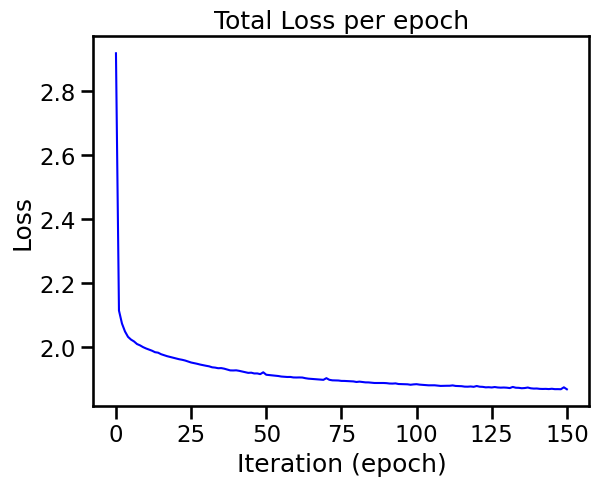

In [10]:
scflash_model.fit(
    batch_size=300, 
    num_epochs=150,
    lr=None, 
    mu0=0.001
    )

## <a id='toc3_4_'></a>[Get the integrated result](#toc0_)
After training，`get_corrected_exp`will return a new AnnData object `adata_int`。

The `adata_int` includes:

1) The corrected gene expression data in `adata_int.X`;

2) The condition-specific cells in `adata_int.obs['specific']`;

3)  The  unknown biological attributes `Zu_emb` and the known condition-specific biological attributes `Zc_emb`;
   
4) Additionally, scFLASH also learns a latent representation for each cell, `Z_emb` = `(Zu_emb, Zc_emb)`.


In [12]:
adata_int = scflash_model.get_corrected_exp(input_dict)
adata_int

AnnData object with n_obs × n_vars = 11884 × 2000
    obs: 'batch', 'celltype', 'condition', 'condition_output', 'specific'
    obsm: 'Z_emb', 'Zu_emb', 'Zc_emb'

## <a id='toc3_5_'></a>[Visualization of the corrected gene expression data](#toc0_)

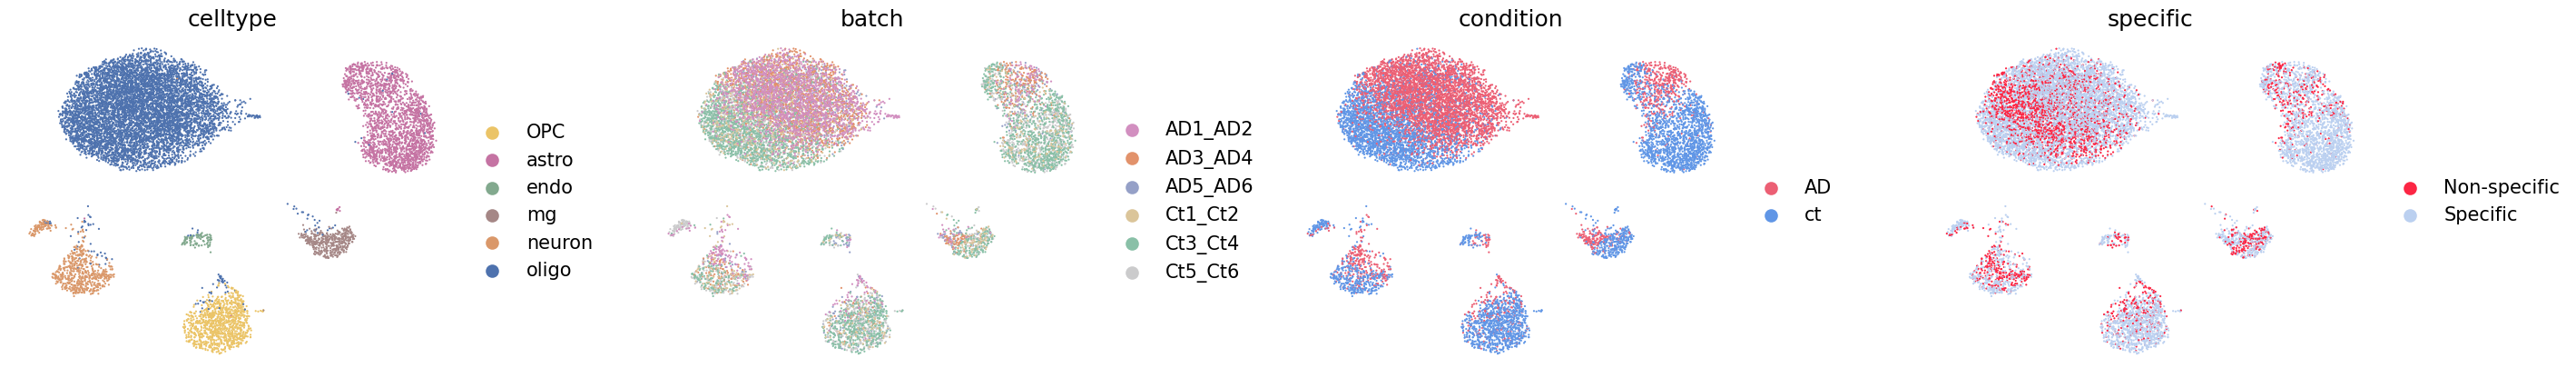

In [ ]:
sc.tl.pca(adata_int, svd_solver='arpack')
sc.pp.neighbors(adata_int,n_neighbors=15,n_pcs=15)
sc.tl.umap(adata_int)


adata_int.uns["celltype_colors"] = ['#ebc467', '#c573a3', '#82a98e', '#a58786', '#da986a', '#4e72ae']
adata_int.uns["batch_colors"] = [ '#d28fc0', '#e2926b','#95a0c7','#dbc59a', '#89c0a7', '#cbcbcc']
adata_int.uns["condition_colors"] = ["#ec5f74", "#6096e6"]
adata_int.uns["specific_colors"] = ['#fc2644', '#bbd0f0']
color_group = ['celltype','batch',"condition", "specific"]
sc.pl.umap(adata_int, color=color_group, legend_fontsize=15, wspace=0.3, frameon=False, size=10)

Note that, we can also visualize the learned biological attributes `Z_emb`, `Zu_emb`, and `Zc_emb`

Current parameter: Z_emb


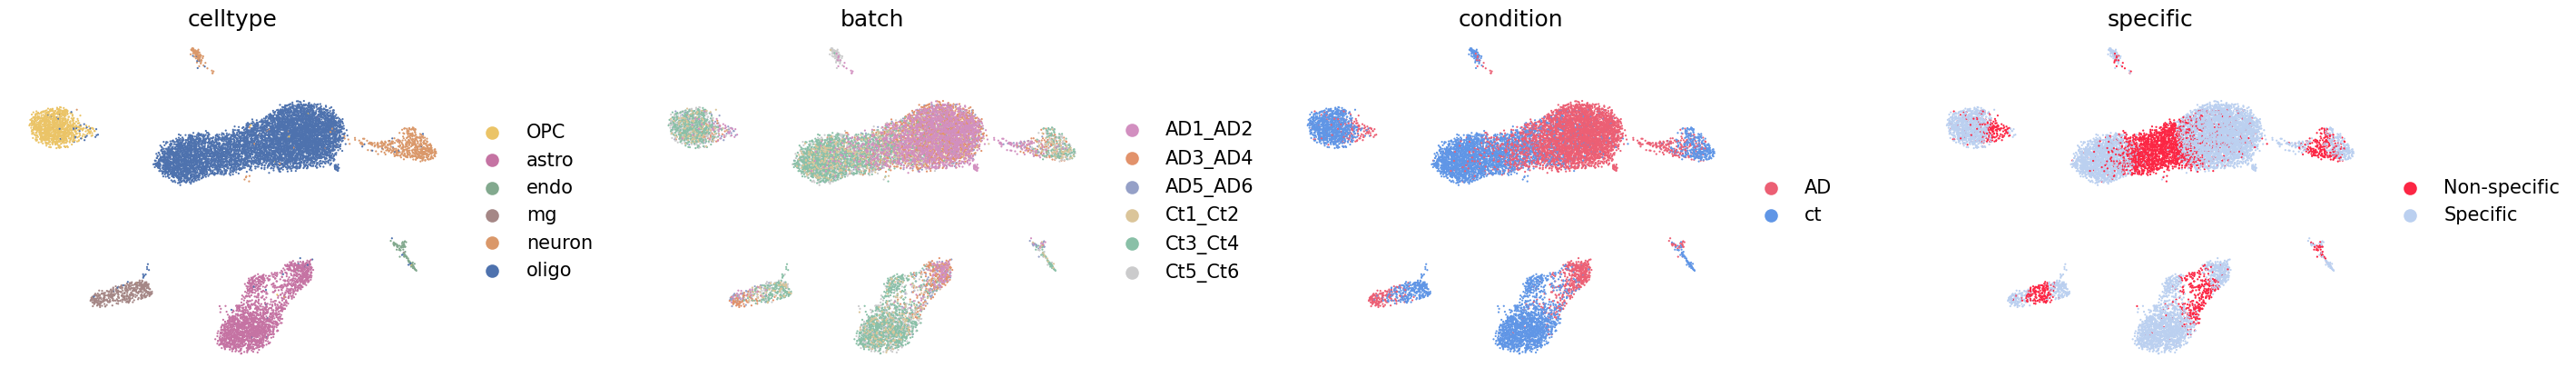

Current parameter: Zu_emb


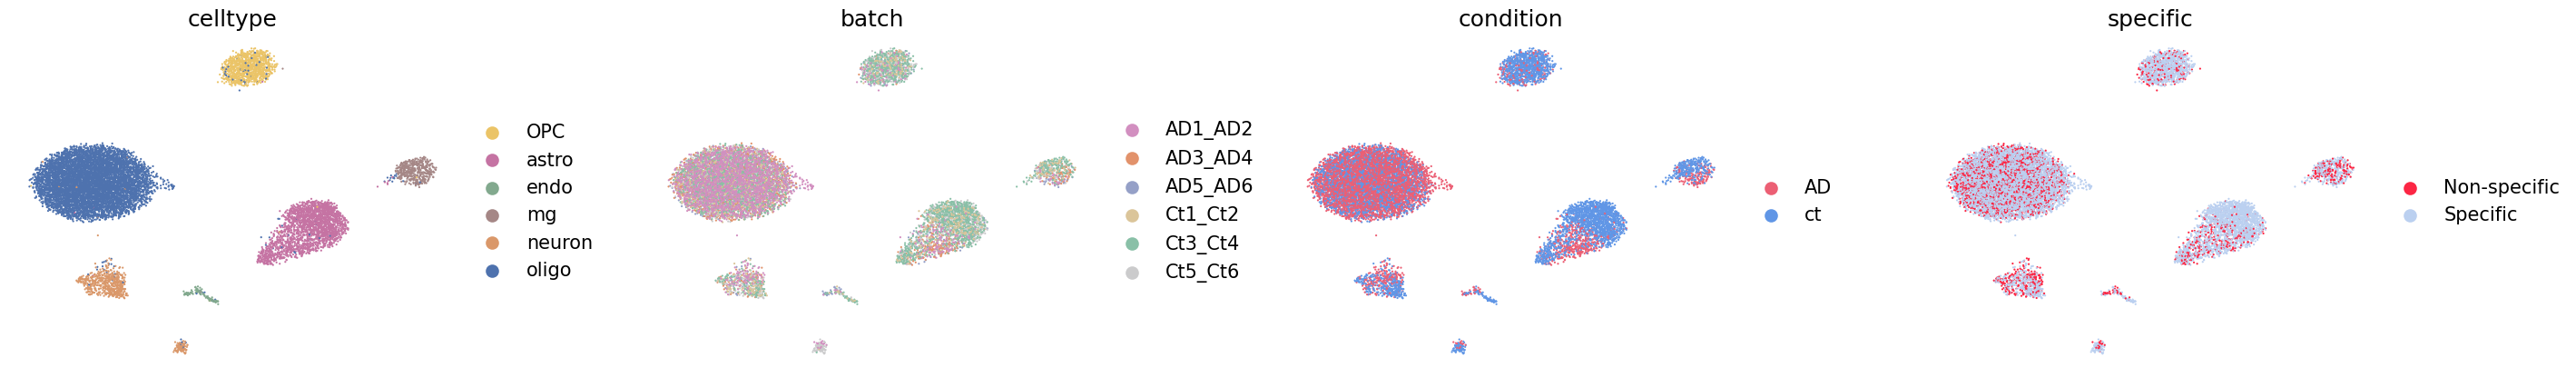

Current parameter: Zc_emb


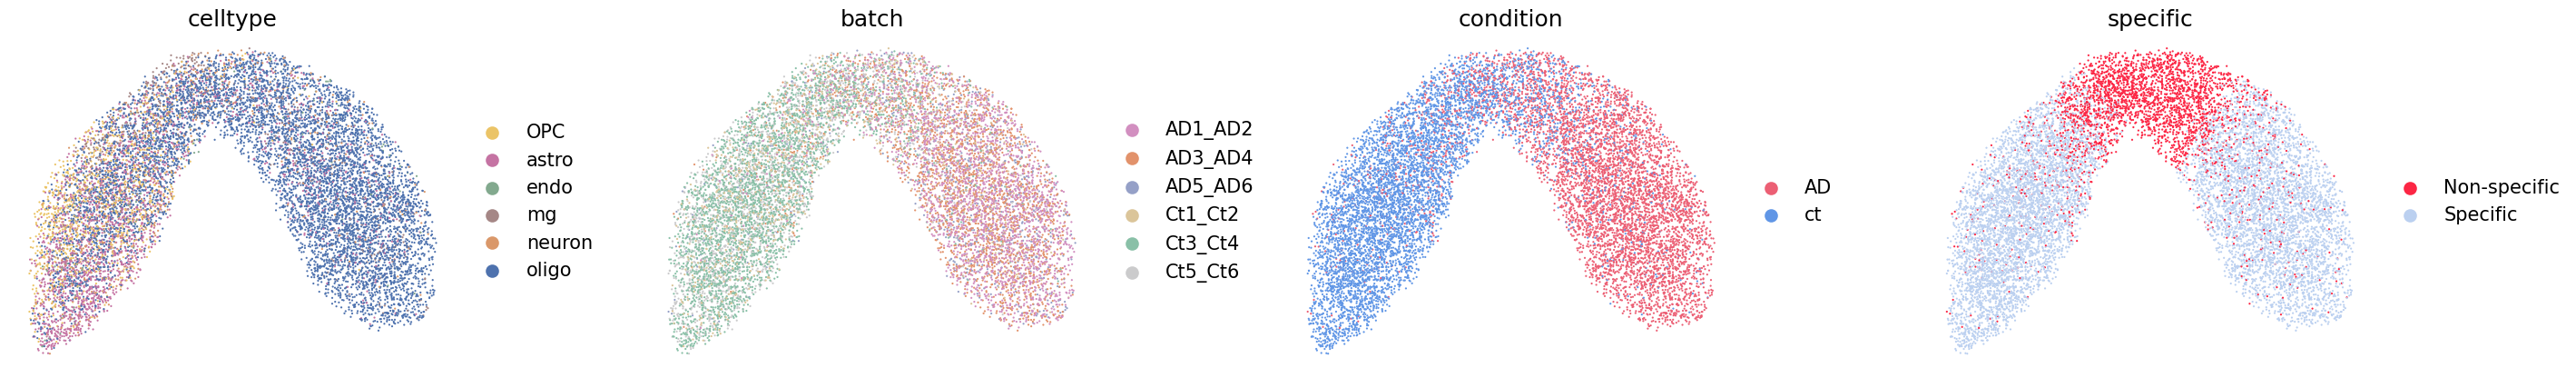

In [16]:
# List of different embedding representations to test
param_values = ["Z_emb", "Zu_emb", "Zc_emb"]

for emb in param_values:
    print(f'Current parameter: {emb}')
    
    # Compute neighbors and UMAP for the current embedding
    sc.pp.neighbors(adata_int, use_rep=emb)
    sc.tl.umap(adata_int)

    # Define the grouping variables for coloring UMAP plots
    color_group = ['celltype', 'batch', "condition", "specific"]
    adata_umap = adata_int

    # Set custom color palettes for each grouping
    adata_umap.uns["celltype_colors"] = ['#ebc467', '#c573a3', '#82a98e', '#a58786', '#da986a','#4e72ae']
    adata_umap.uns["batch_colors"] = ['#d28fc0', '#e2926b','#95a0c7','#dbc59a', '#89c0a7', '#cbcbcc']
    adata_umap.uns["condition_colors"] = ["#ec5f74", "#6096e6"]
    adata_umap.uns["specific_colors"] = ['#fc2644','#bbd0f0']

    # Plot UMAP with the specified color groups and settings
    sc.pl.umap(adata_umap, color=color_group, legend_fontsize=15, wspace=0.3,  frameon=False, size=10)




## <a id='toc3_6_'></a>[Evaluation](#toc0_)

The `metric` function in `scFLASH` integrates several evaluation metrics for assessing:
1. Biological conservation: NMI, and ARI;
2. Batch correction: ASW_batch, and iLISI;
3. Condition conservation: ASW_cond, and cond_knn.

It is simple to use and allows flexibility with parameters like `cal_iLISI=True`. 

**Note**: If you choose to calculate the iLISI metric (`cal_iLISI=True`), you need to compile `knn_graph.cpp` in the shell. Follow these steps:

1. Navigate to the `knn_graph` directory within your Python environment:
   ```bash
   cd /path_to_your_conda/envs/scFLASH/lib/python3.8/site-packages/scib/knn_graph
   ```

2. Compile using g++:
   ```bash
   g++ -std=c++11 -O3 knn_graph.cpp -o knn_graph
   ```




NMI...
ARI...
Silhouette score...
iLISI score...
Silhouette score...


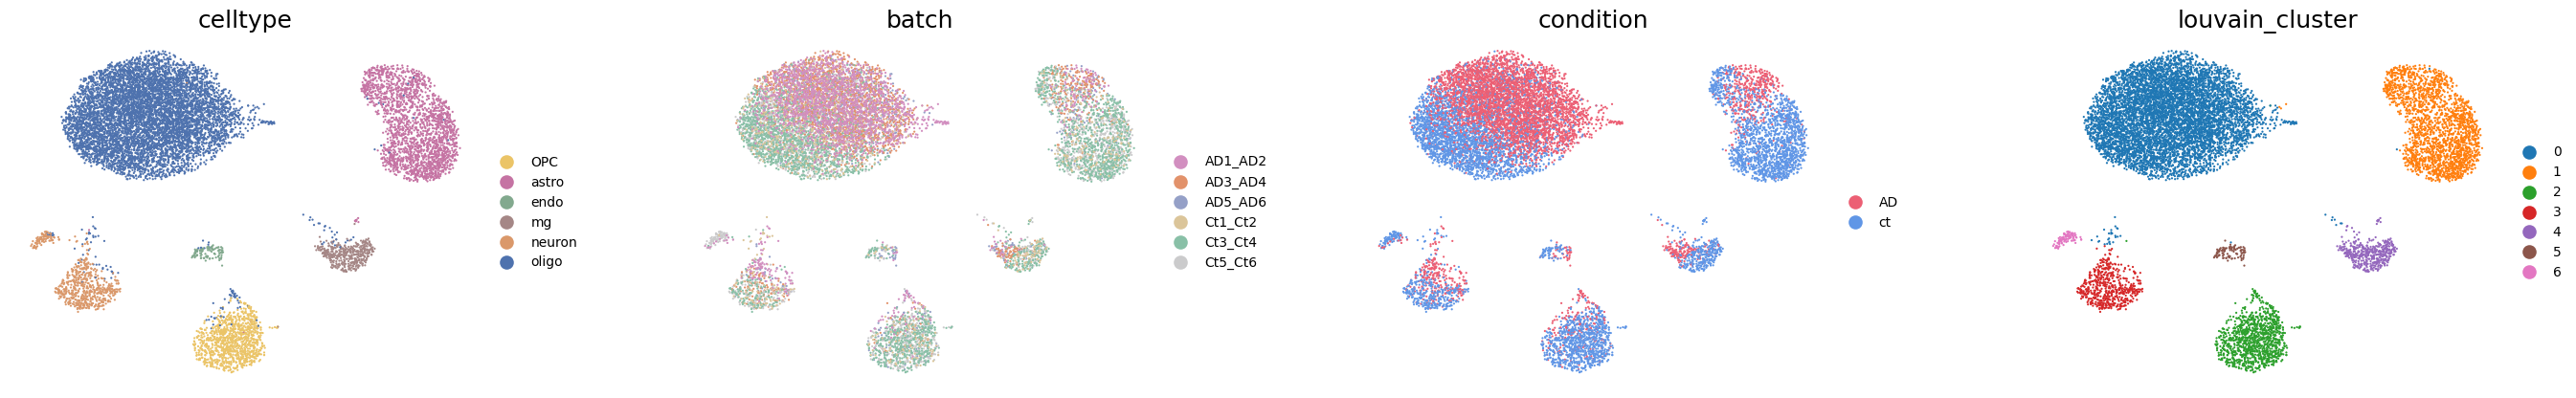

Calculate ASW_cond for each cell type: 100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


Calculating KNN-based performance...


,Metric Type,Value
NMI,Bio conservation,0.931249
ARI,Bio conservation,0.966343
ASW_batch,Batch correction,0.929859
iLISI,Batch correction,0.448546
ASW_cond,Cond conservation,0.546521
cond_knn,Cond conservation,0.855436


In [17]:
adata_int, df_metric = scFLASH.metric(adata, adata_int, cal_iLISI=True)
df_metric

# <a id='toc4_'></a>[Reference](#toc0_)

Effectively preserving biological variations in multi-batch and multi-condition single-cell data integration.